Jupyter notebook that implements an ensemble learner by row subsetting. Data is the Kaggle mushroom classification dataset. https://www.kaggle.com/datasets/uciml/mushroom-classification

The notebook cleans and encodes the data. Then does 10-fold CV on a few different sklearn models. Then implements an ensemble learner based on row subsetting using an input subsample ratio. The prediction of the ensemble learner is made by majority voting of the classifiers. It uses the same few sklearn models for the individual classifiers in the ensemble. 



In [1]:
import pandas as pd

#read in the data
df = pd.read_csv('mushroom_dataset.csv')

#take a look at data
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

In [3]:
with pd.option_context('display.max_columns', 40):
    print(df.describe(include='all'))

       class cap-shape cap-surface cap-color bruises  odor gill-attachment  \
count   8124      8124        8124      8124    8124  8124            8124   
unique     2         6           4        10       2     9               2   
top        e         x           y         n       f     n               f   
freq    4208      3656        3244      2284    4748  3528            7914   

       gill-spacing gill-size gill-color stalk-shape stalk-root  \
count          8124      8124       8124        8124       8124   
unique            2         2         12           2          5   
top               c         b          b           t          b   
freq           6812      5612       1728        4608       3776   

       stalk-surface-above-ring stalk-surface-below-ring  \
count                      8124                     8124   
unique                        4                        4   
top                           s                        s   
freq                       5176  

This data looks pretty clean, mostly just need to encode. I'm going to drop veil-type because it's the same for everything. Then label encode columns with 2 unique variables. One hot encode the rest of the columns. 

In [4]:
#get values for binary variable label encoding
print(df['class'].unique())
print(df['bruises'].unique())
print(df['gill-attachment'].unique())
print(df['gill-spacing'].unique())
print(df['gill-size'].unique())
print(df['stalk-shape'].unique())

['p' 'e']
['t' 'f']
['f' 'a']
['c' 'w']
['n' 'b']
['e' 't']


In [5]:
#drop veil-type
df.drop('veil-type', axis = 1, inplace = True)

#label encode binary variables
df['class'] = df['class'].map({'p': 0, 'e': 1})
df['bruises'] = df['bruises'].map({'t': 0, 'f': 1})
df['gill-attachment'] = df['gill-attachment'].map({'f': 0, 'a': 1})
df['gill-spacing'] = df['gill-spacing'].map({'c': 0, 'w': 1})
df['gill-size'] = df['gill-size'].map({'n': 0, 'b': 1})
df['stalk-shape'] = df['stalk-shape'].map({'e': 0, 't': 1})

df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,0,x,s,n,0,p,0,0,0,k,...,s,s,w,w,w,o,p,k,s,u
1,1,x,s,y,0,a,0,0,1,k,...,s,s,w,w,w,o,p,n,n,g
2,1,b,s,w,0,l,0,0,1,n,...,s,s,w,w,w,o,p,n,n,m
3,0,x,y,w,0,p,0,0,0,n,...,s,s,w,w,w,o,p,k,s,u
4,1,x,s,g,1,n,0,1,1,k,...,s,s,w,w,w,o,e,n,a,g


In [6]:
#one hot encode remaining columns
import pandas as pd

# list categorical columns
categorical_cols = ['cap-shape', 'cap-surface', 'cap-color', 'odor', 'gill-color', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-color', 'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat']

#encode with get_dummies
df1 = pd.get_dummies(df, columns=categorical_cols)

#check it
df1.head()

,class,bruises,gill-attachment,gill-spacing,gill-size,stalk-shape,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,...,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,1,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,1,1,0,1,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [7]:
#assign X and y. class is the variable we are trying to classify as it is the class of mushroom
y = df1['class']
X = df1.drop('class', axis = 1).values

print(X)
print(y)

[[0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 1 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 1 0 ... 0 0 0]]
0       0
1       1
2       1
3       0
4       1
       ..
8119    1
8120    1
8121    1
8122    0
8123    1
Name: class, Length: 8124, dtype: int64


In [8]:
#10-fold CV on some classic sklearn classifiers


from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np

# function to evaluate 10-fold CV evaluation of a single classifier
def eval_classifier(_clf, _X, _y):
    acc = []
    kf = StratifiedKFold(n_splits=10, shuffle=False, random_state=None)
    for train_index, test_index in kf.split(_X, _y):
        _clf.fit(_X[train_index], _y[train_index])
        y_pred = _clf.predict(_X[test_index])
        acc += [accuracy_score(_y[test_index], y_pred)]
    return np.array(acc)

In [9]:
from sklearn.naive_bayes import GaussianNB

acc = eval_classifier(GaussianNB(),
                      X, y)
print(f'Naive Bayes CV accuracy={np.mean(acc):.2f} {chr(177)}{np.std(acc):.3f}')

Naive Bayes CV accuracy=0.91 ±0.084


In [10]:
from sklearn.svm import SVC

acc = eval_classifier(SVC(kernel='linear', probability=True),
                      X, y)
print(f'Linear SVC CV accuracy={np.mean(acc):.2f} {chr(177)}{np.std(acc):.3f}')

Linear SVC CV accuracy=0.97 ±0.070


In [11]:
from sklearn.neural_network import MLPClassifier

acc = eval_classifier(MLPClassifier(),
                      X, y)
print(f'Neural Network CV accuracy={np.mean(acc):.2f} {chr(177)}{np.std(acc):.3f}')

Neural Network CV accuracy=0.96 ±0.094


In [12]:
from sklearn.tree import DecisionTreeClassifier

acc = eval_classifier(DecisionTreeClassifier(),
                      X, y)
print(f'Decision Tree CV accuracy={np.mean(acc):.2f} {chr(177)}{np.std(acc):.3f}')

Decision Tree CV accuracy=0.97 ±0.094


In [13]:
from sklearn.ensemble import RandomForestClassifier

acc = eval_classifier(RandomForestClassifier(),
                      X, y)
print(f'Random Forest CV accuracy={np.mean(acc):.2f} {chr(177)}{np.std(acc):.3f}')

Random Forest CV accuracy=0.97 ±0.094


In [14]:
#Generate the ensembles of classifiers 

N_ENSEMBLE = 100

ens_NB = [GaussianNB() for _ in range(N_ENSEMBLE)]
ens_SVC = [SVC(kernel='linear', probability=True) for _ in range(N_ENSEMBLE)]
ens_MLP = [MLPClassifier(hidden_layer_sizes = (3, 3), max_iter = 30, tol = 1e-1) for _ in range(N_ENSEMBLE)]
ens_DTC = [DecisionTreeClassifier(max_depth = 5, max_features = 5) for _ in range(N_ENSEMBLE)]

In [15]:
#evaluate the performance of the first classifier in each ensemble
acc = eval_classifier(ens_NB[0], X, y)
print(f'Naive Bayes CV accuracy={np.mean(acc):.2f} {chr(177)}{np.std(acc):.3f}')

acc = eval_classifier(ens_SVC[0], X, y)
print(f'Linear SVC CV accuracy={np.mean(acc):.2f} {chr(177)}{np.std(acc):.3f}')

acc = eval_classifier(ens_MLP[0], X, y)
print(f'Neural Network CV accuracy={np.mean(acc):.2f} {chr(177)}{np.std(acc):.3f}')

acc = eval_classifier(ens_DTC[0], X, y)
print(f'Decision Tree CV accuracy={np.mean(acc):.2f} {chr(177)}{np.std(acc):.3f}')

Naive Bayes CV accuracy=0.91 ±0.084
Linear SVC CV accuracy=0.97 ±0.070
Neural Network CV accuracy=0.90 ±0.165
Decision Tree CV accuracy=0.84 ±0.152


In [16]:
import random

#function to fit individual classifiers in an ensemble with randomly subsampled rows of data based on subsample ratio
#input: a list of untrained classifiers, X and y, subsample ratio
#output: a list of trained classifiers
def ensemble_fit(_ens_clf, _X, _y, subs_ratio):
    # get number of classifiers in input
    n_estimators = len(_ens_clf)
    
    # get number of rows in data
    N = _X.shape[0]
    
    # list for trained classifiers
    ensemble_clf = []
    
    #for each classifier
    for j in range(n_estimators):
        #get a list of random indices based on sabsample index
        index_x = random.sample(range(N), int(subs_ratio*N))
        
        #subset X and y with that list of indices
        subs_X = np.take(_X, index_x, axis=0)
        subs_y = _y.iloc[index_x]
        
        #fit the classifier to the subsetted data and add to the list
        ensemble_clf += [_ens_clf[j].fit(subs_X, subs_y)]
        
    return ensemble_clf



In [17]:
#sanity check that the classifiers in the list are different
NB = ensemble_fit(ens_NB, X, y, 0.1)

y_pred = NB[0].predict(X)
acc = accuracy_score(y, y_pred)
print(acc)

y_pred = NB[1].predict(X)
acc = accuracy_score(y, y_pred)
print(acc)

0.9155588380108322
0.9087887740029542


In [18]:
# function that predicts with an ensemble of trained classifiers based on majority voting
# input: trained list of classifiers, X test data
# output: an array of y predictions
def ensemble_predict(_ensemble_clf, _Xtest):
    from collections import defaultdict
    
    n_estimators = len(_ensemble_clf)

    ypred_e, yprob_e = [], []
    
    #get the predictions and probas for each classifier
    for j in range(n_estimators):
        res = _ensemble_clf[j].predict(_Xtest), _ensemble_clf[j].predict_proba(_Xtest)
        ypred_e += [res[0]]
        yprob_e += [res[1]]  
    
    # majority voting for each data point in _Xtest
    ypred = []
    for i in range(_Xtest.shape[0]):
        ypred_scores = defaultdict(float)
        for j in range(n_estimators):
            for c, p in enumerate(yprob_e[j][i]):
                # a proper score is necessary
                ypred_scores[c] += p
        ix = max(ypred_scores.items(), key=lambda a: a[1])
        ypred += [ix[0]]

    return np.array(ypred)

In [19]:
#sanity check that the function works
NB = ensemble_fit(ens_NB, X, y, 0.005)

y_pred = ensemble_predict(NB, X)
acc = accuracy_score(y, y_pred)
print(acc)

0.9615952732644018


In [20]:
#function to evaluate 10-fold CV accuracy of an ensemble learner
# input: an untrained list of classifers, X and y data, subsample ratio
# output: array of accuracies for each fold of the CV
def eval_ensemble(_ens_clf, _X, _y, subs_ratio):
    acc = []
    kf = StratifiedKFold(n_splits=10, shuffle=False, random_state=None)
    for train_index, test_index in kf.split(_X, _y):
        fit_clf = ensemble_fit(_ens_clf, _X[train_index], _y[train_index], subs_ratio)
        y_pred = ensemble_predict(_ens_clf, _X[test_index])
        acc += [accuracy_score(_y[test_index], y_pred)]
    return np.array(acc)

In [21]:
#sanity check that the function works
acc = eval_ensemble(ens_SVC, X, y, 0.002)
print(acc)

[0.6199262  0.84501845 0.9901599  0.98277983 0.85221675 0.84605911
 1.         0.99753695 0.87438424 0.9679803 ]


In [22]:
#Evaluate the ensembles previously declared
acc = eval_ensemble(ens_NB, X, y, 0.1)
print(f'Naive Bayes ensemble with 0.1 subsample ratio accuracy={np.mean(acc):.2f} {chr(177)}{np.std(acc):.3f}')

acc = eval_ensemble(ens_SVC, X, y, 0.1)
print(f'SVC ensemble with 0.1 subsample ratio accuracy={np.mean(acc):.2f} {chr(177)}{np.std(acc):.3f}')

acc = eval_ensemble(ens_MLP, X, y, 0.1)
print(f'MLP ensemble with 0.1 subsample ratio accuracy={np.mean(acc):.2f} {chr(177)}{np.std(acc):.3f}')

acc = eval_ensemble(ens_DTC, X, y, 0.1)
print(f'DTC ensemble with 0.1 subsample ratio accuracy={np.mean(acc):.2f} {chr(177)}{np.std(acc):.3f}')

acc = eval_ensemble([DecisionTreeClassifier(),], X, y, 0.1)
print(f'Single decision tree with 0.1 subsample ratio accuracy={np.mean(acc):.2f} {chr(177)}{np.std(acc):.3f}')

Naive Bayes ensemble with 0.1 subsample ratio accuracy=0.84 ±0.075
SVC ensemble with 0.1 subsample ratio accuracy=0.93 ±0.133
MLP ensemble with 0.1 subsample ratio accuracy=0.91 ±0.117
DTC ensemble with 0.1 subsample ratio accuracy=0.94 ±0.094
Single decision tree with 0.1 subsample ratio accuracy=0.96 ±0.092


In [23]:
acc = eval_ensemble(ens_NB, X, y, 0.001)
print(f'Naive Bayes ensemble with 0.001 subsample ratio accuracy={np.mean(acc):.2f} {chr(177)}{np.std(acc):.3f}')

# any subsample ratio below 0.001 is causing an error with SVC. I believe it has something to do with too few data 
# points for the classifier (as subsample ratio gets smaller, number of data points for training gets fewer)

#acc = eval_ensemble(ens_SVC, X, y, 0.001)
#print(f'SVC ensemble with 0.001 subsample ratio accuracy={np.mean(acc):.2f} {chr(177)}{np.std(acc):.3f}')

acc = eval_ensemble(ens_MLP, X, y, 0.001)
print(f'MLP ensemble with 0.001 subsample ratio accuracy={np.mean(acc):.2f} {chr(177)}{np.std(acc):.3f}')

acc = eval_ensemble(ens_DTC, X, y, 0.001)
print(f'DTC ensemble with 0.001 subsample ratio accuracy={np.mean(acc):.2f} {chr(177)}{np.std(acc):.3f}')

acc = eval_ensemble([DecisionTreeClassifier(),], X, y, 0.001)
print(f'Single decision tree with 0.001 subsample ratio accuracy={np.mean(acc):.2f} {chr(177)}{np.std(acc):.3f}')

Naive Bayes ensemble with 0.001 subsample ratio accuracy=0.86 ±0.140
MLP ensemble with 0.001 subsample ratio accuracy=0.58 ±0.136
DTC ensemble with 0.001 subsample ratio accuracy=0.88 ±0.116
Single decision tree with 0.001 subsample ratio accuracy=0.78 ±0.142


In [24]:
#generate some data to plot performance of ensembles and their respective individual classifiers 
#based on subsample ratio

subsamples = [0.0005, 0.001, 0.005, 0.01, 0.03, 0.05, 0.1] 

acc = []

nb_acc_mean = []
svc_acc_mean = []
mlp_acc_mean = []
dtc_acc_mean = []

nb_reg_acc = []
svc_reg_acc = []
mlp_reg_acc = []
dtc_reg_acc = []

for subsample in subsamples :
    #ensembles
    acc = eval_ensemble(ens_NB, X, y, subsample)
    nb_acc_mean += [np.mean(acc)]
    
    acc = eval_ensemble(ens_MLP, X, y, subsample)
    mlp_acc_mean += [np.mean(acc)]
    
    acc = eval_ensemble(ens_DTC, X, y, subsample)
    dtc_acc_mean += [np.mean(acc)]
    
    #single classifiers
    acc = eval_ensemble((GaussianNB(),), X, y, subsample)
    nb_reg_acc += [np.mean(acc)]
    
    acc = eval_ensemble((MLPClassifier(hidden_layer_sizes = (3, 3), max_iter = 30, tol = 1e-1),), X, y, subsample)
    mlp_reg_acc += [np.mean(acc)]
    
    acc = eval_ensemble((DecisionTreeClassifier(max_depth = 5, max_features = 5),), X, y, subsample)
    dtc_reg_acc += [np.mean(acc)]

    



In [25]:
# SVC ensemble and single data
svc_subsamples = [0.005, 0.01, 0.03, 0.05, 0.1] 

svc_acc_mean = []

for subsample in svc_subsamples :
    acc = eval_ensemble(ens_SVC, X, y, subsample)
    svc_acc_mean += [np.mean(acc)]
    
    acc = eval_ensemble((SVC(kernel='linear', probability=True),), X, y, subsample)
    svc_reg_acc += [np.mean(acc)]

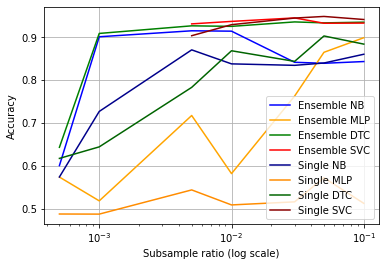

In [26]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors 


# Plot ensembles
plt.plot(subsamples, nb_acc_mean, label='Ensemble NB', color='blue')
plt.plot(subsamples, mlp_acc_mean, label='Ensemble MLP', color='orange')
plt.plot(subsamples, dtc_acc_mean, label='Ensemble DTC', color = 'green')
plt.plot(svc_subsamples, svc_acc_mean, label='Ensemble SVC', color='red')

#plot singles
plt.plot(subsamples, nb_reg_acc, label='Single NB', color='darkblue')
plt.plot(subsamples, mlp_reg_acc, label='Single MLP', color='darkorange')
plt.plot(subsamples, dtc_reg_acc, label='Single DTC', color='darkgreen')
plt.plot(svc_subsamples, svc_reg_acc, label='Single SVC', color='darkred')

plt.xlabel('Subsample ratio (log scale)')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.xscale('log')
plt.grid()
plt.show()